In [1]:
%matplotlib widget
%matplotlib inline
import sys
from sys import platform
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.ticker import ScalarFormatter
from matplotlib.gridspec import GridSpec
import copy
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

import numpy as np
import pickle
import seaborn as sns
import scipy
import emcee
import corner
from IPython.display import display, Math
from tqdm import tqdm
from multiprocessing import Pool

import stingray.events as ev
import stingray.lightcurve as lc
from stingray import io
import stingray.powerspectrum as powspec 
import stingray.crossspectrum as crossspec
from stingray import stats
from stingray.simulator import simulator as sim
from stingray.simulator import models as mod

def four_lorentz(x, n=0):
    tot_model= np.array([0 for i in range(len(x))])
    x_0s= [0.001, 0.758, 5.39, 37.2]
    fwhms = [1.0, 0.1, 10.0,100.0]
    values= [0.04, 6e-3/0.758, 3e-3/5.39, 5e-4/37.2]
        
    for i in range(n):
        tot_model = tot_model + mod.generalized_lorentzian(x, [x_0s[i], fwhms[i], values[i], 2.0])
        
    return tot_model
    



sns.set_context('talk')
# sns.set_style("whitegrid")
sns.set_palette("colorblind")



/Users/sean/opt/anaconda3/lib/python3.8/site-packages/stingray/largememory.py:25: UserWarning: Large Datasets may not be processed efficiently due to computational constraints
  warnings.warn(
/Users/sean/opt/anaconda3/lib/python3.8/site-packages/stingray/crossspectrum.py:28: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn("pyfftw not installed. Using standard scipy fft")
/Users/sean/opt/anaconda3/lib/python3.8/site-packages/stingray/crosscorrelation.py:8: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn("pyfftw not installed. Using standard scipy fft")
/Users/sean/opt/anaconda3/lib/python3.8/site-packages/stingray/bispectrum.py:10: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn("pyfftw not installed. Using standard scipy fft")


/Users/sean/opt/anaconda3/lib/python3.8/site-packages/stingray/utils.py:126: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment. All analysis in the light curve will assume Poisson errors. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/var/folders/bs/3q1_zdjn6b59l3mxccjw3wmm0000gn/T/ipykernel_40745/2161104986.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/Users/sean/opt/anaconda3/lib/python3.8/site-packages/stingray/utils.py:126: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment. All analysis in the light curve will assume Poisson errors. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/var/folders/bs/3q1_zdjn6b59l3mxccjw3wmm0000gn/T/ipykernel_40745/2161104986.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results m

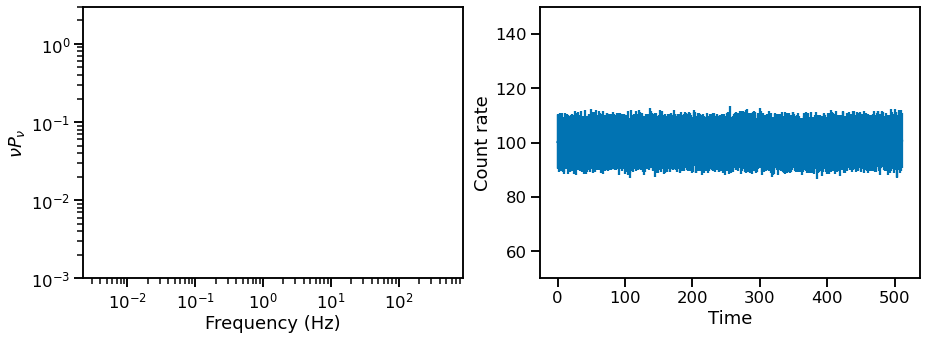

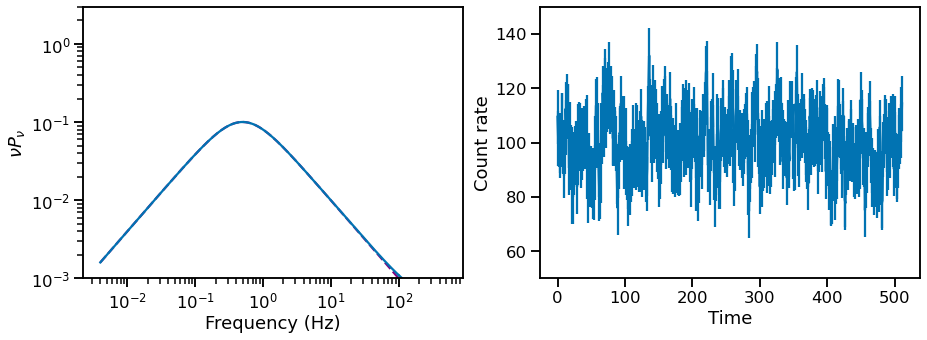

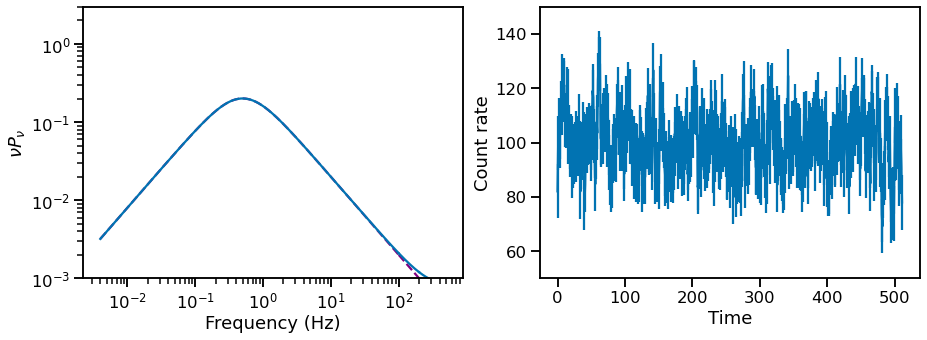

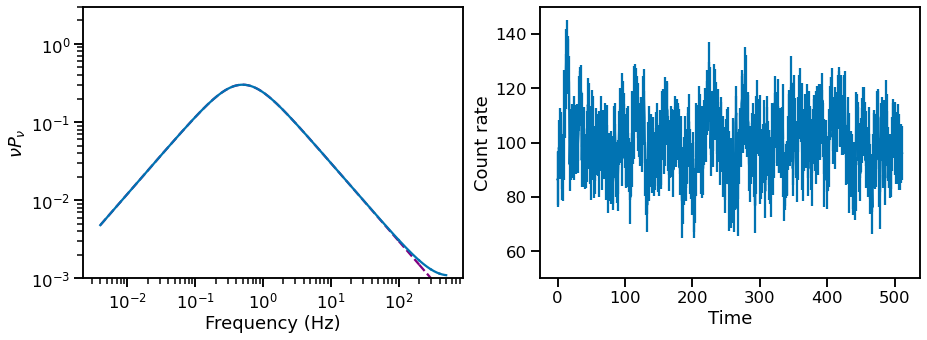

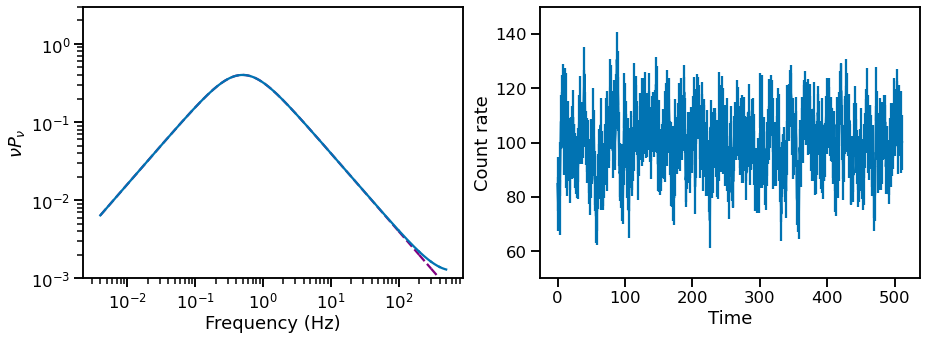

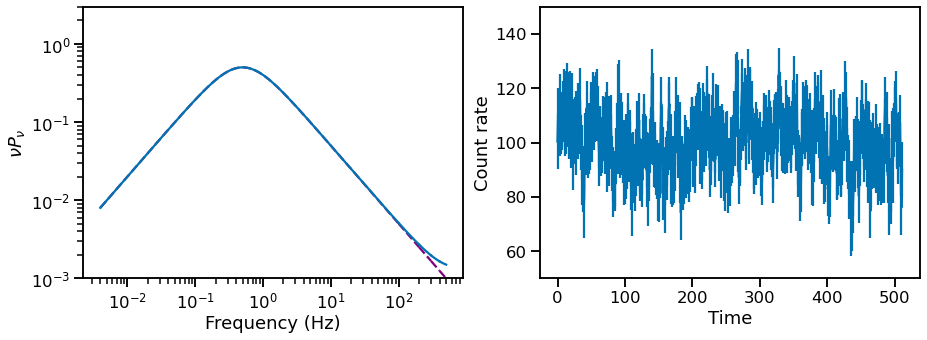

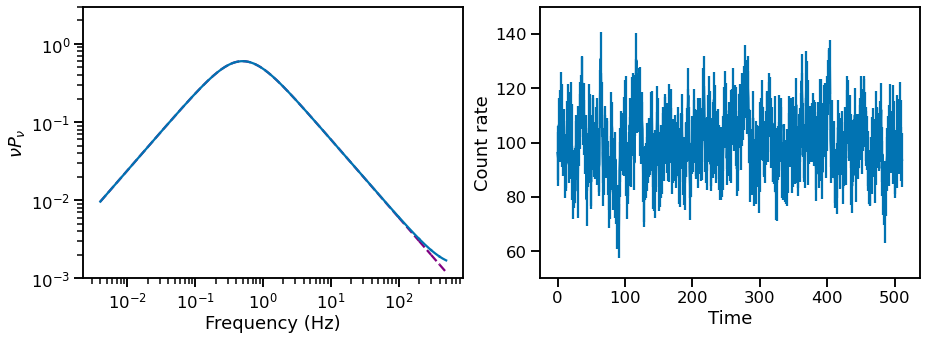

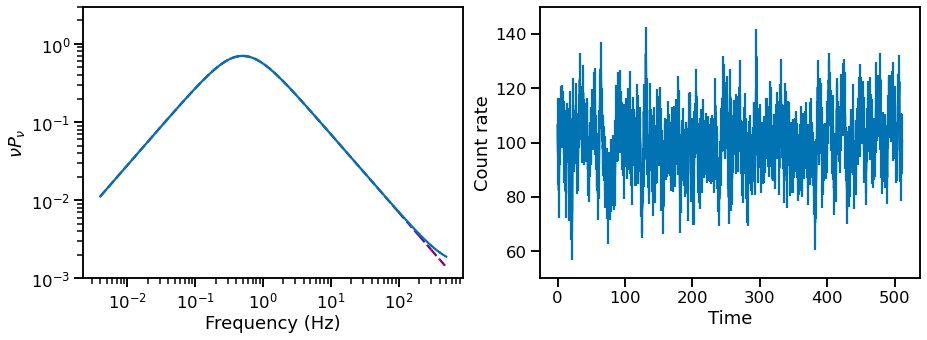

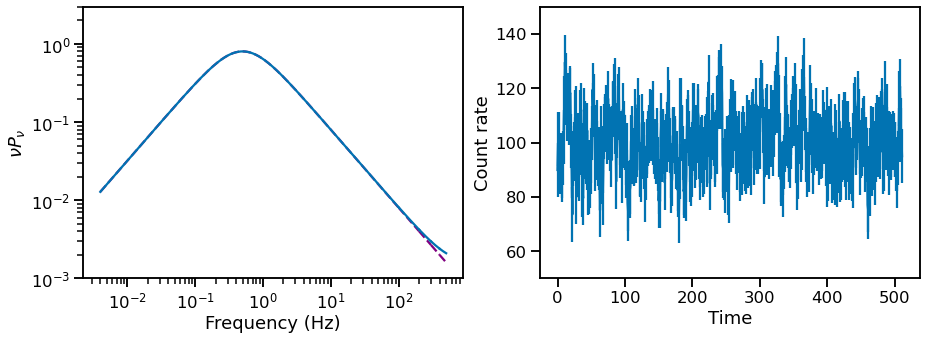

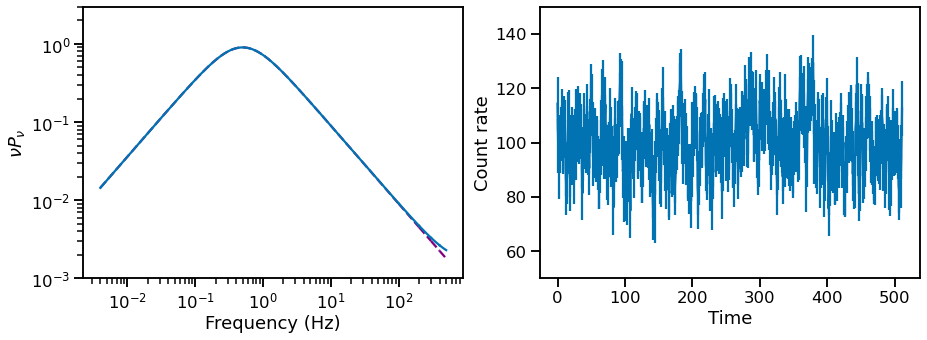

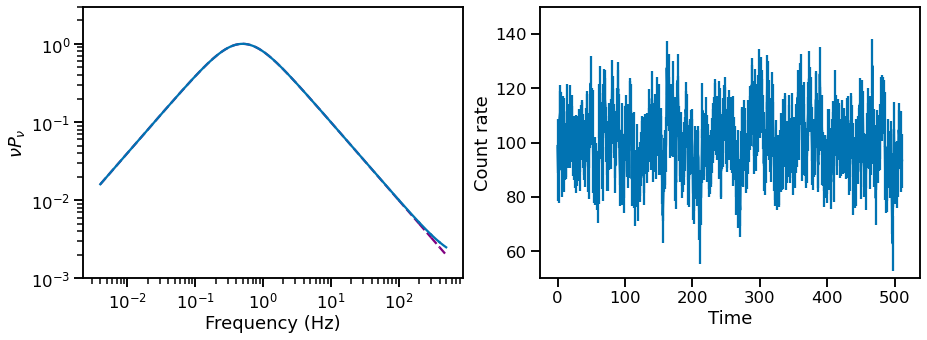

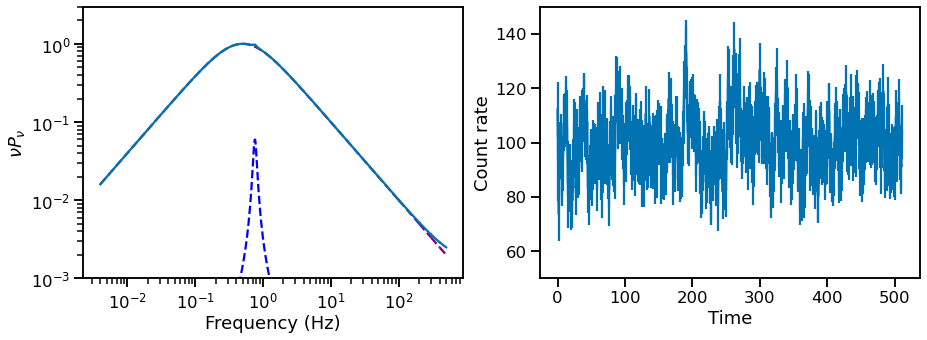

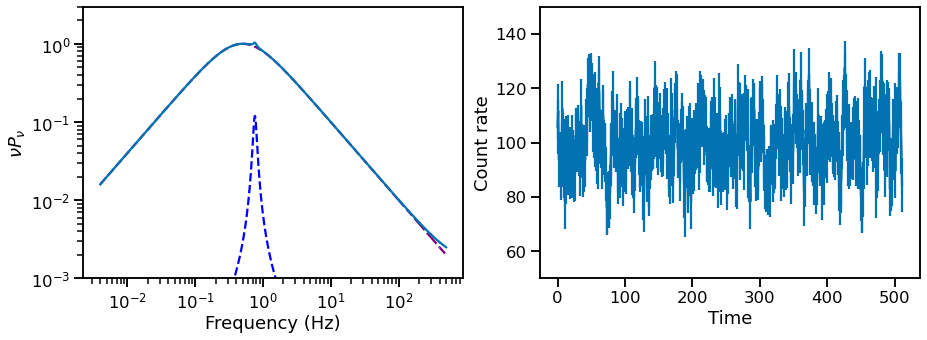

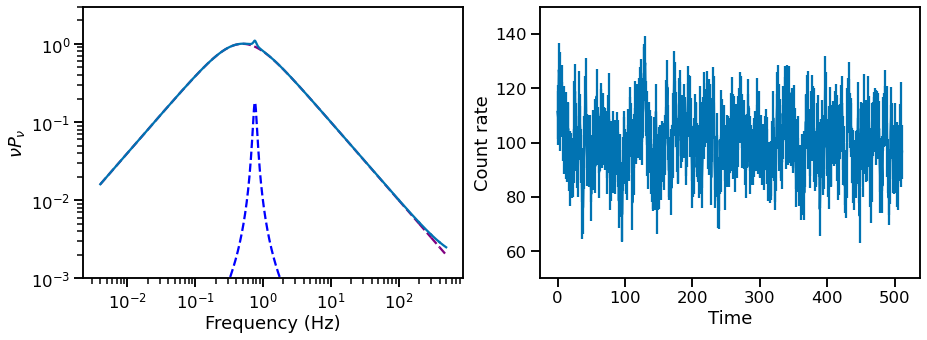

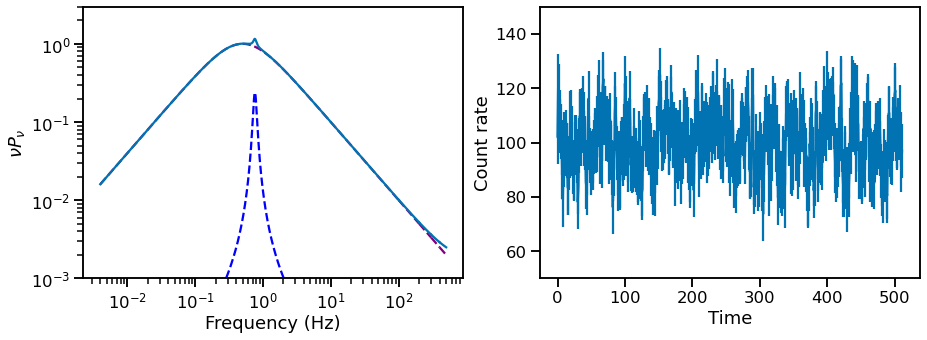

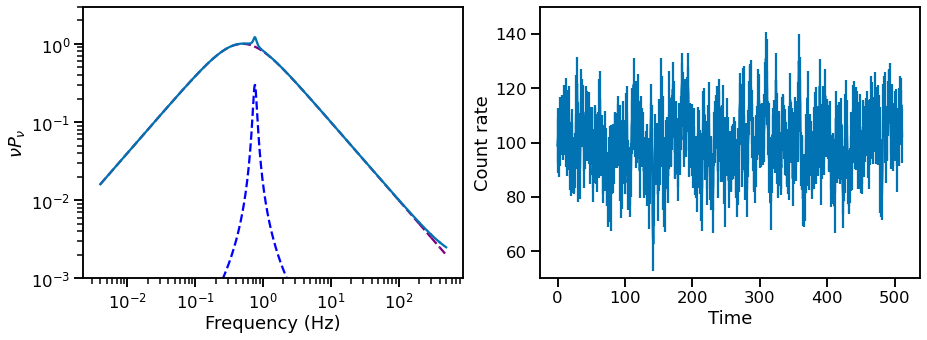

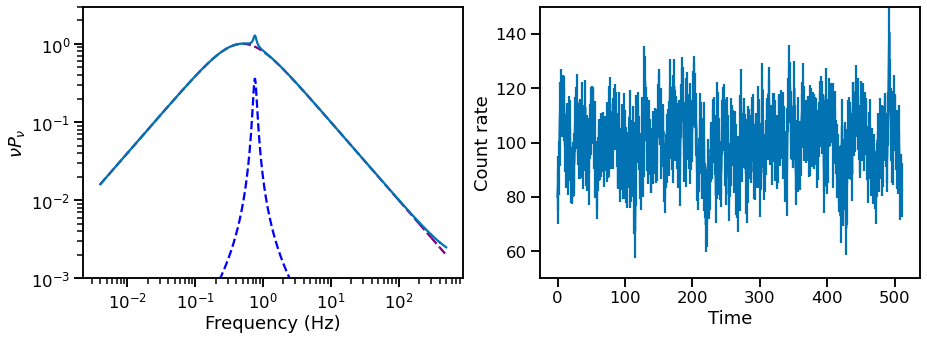

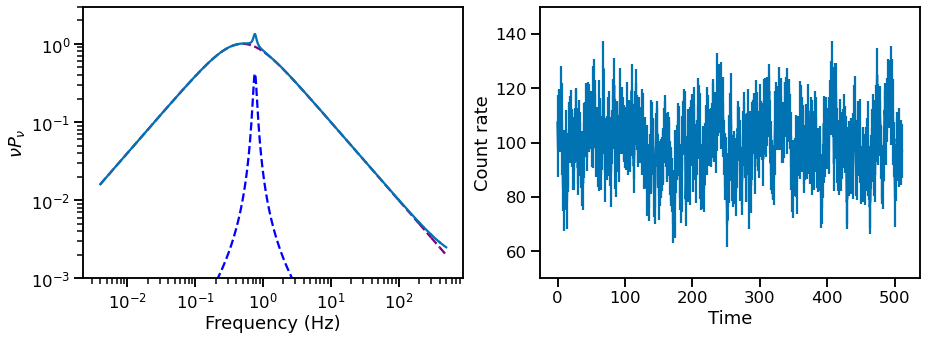

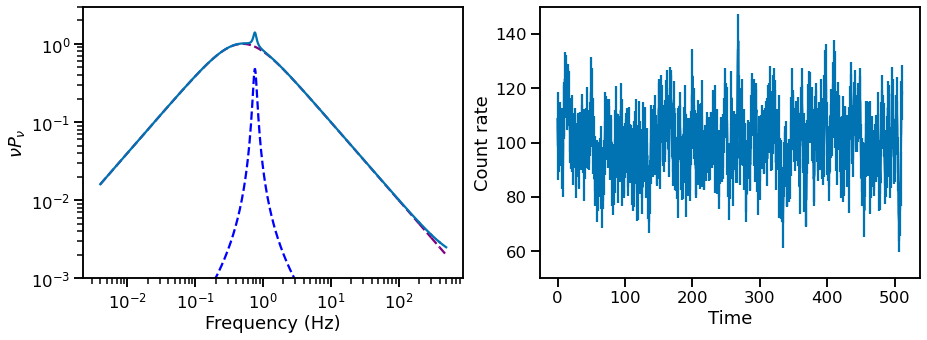

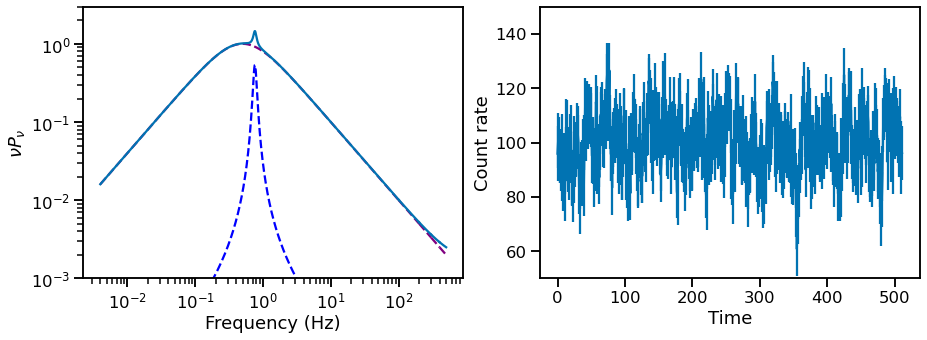

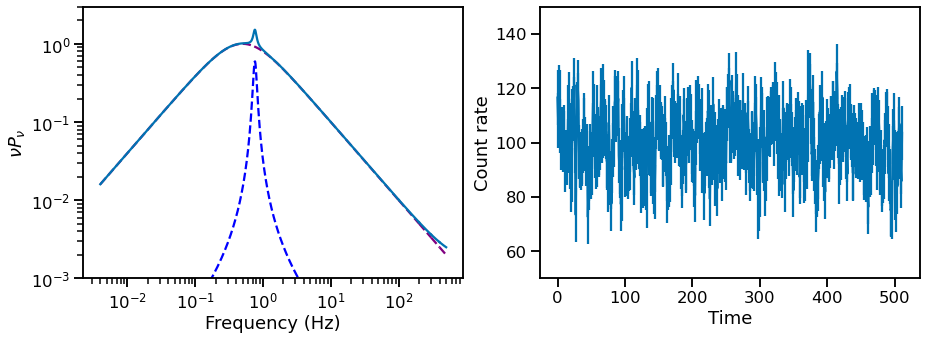

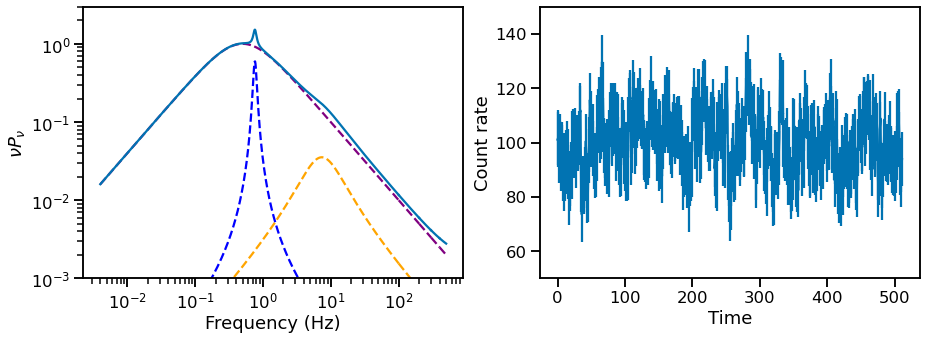

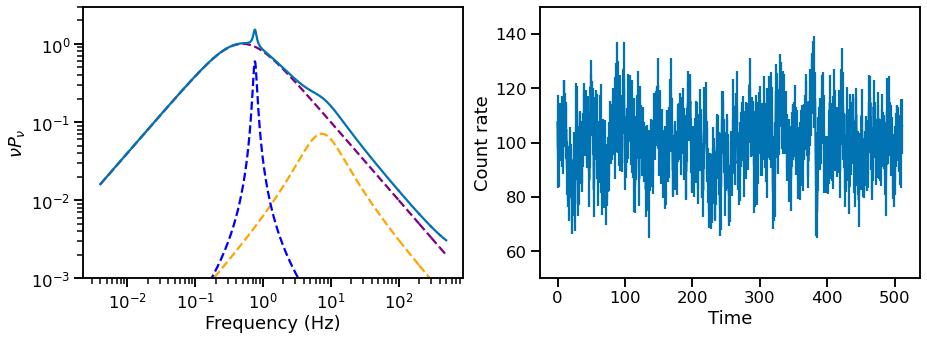

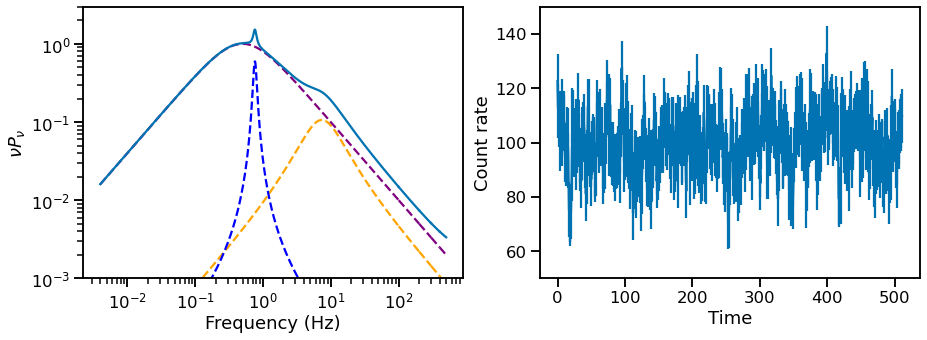

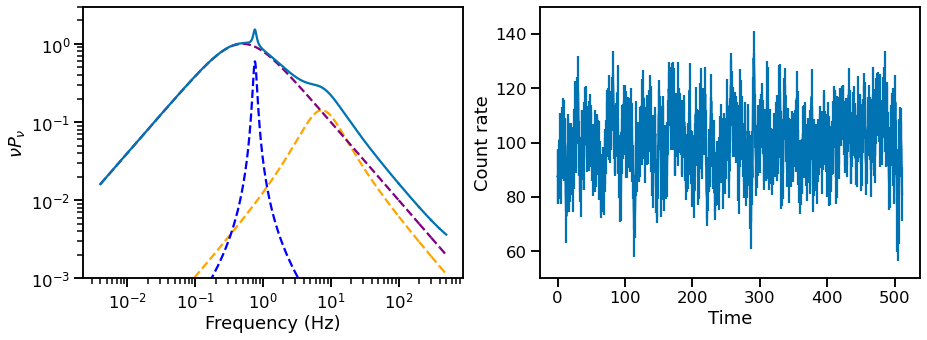

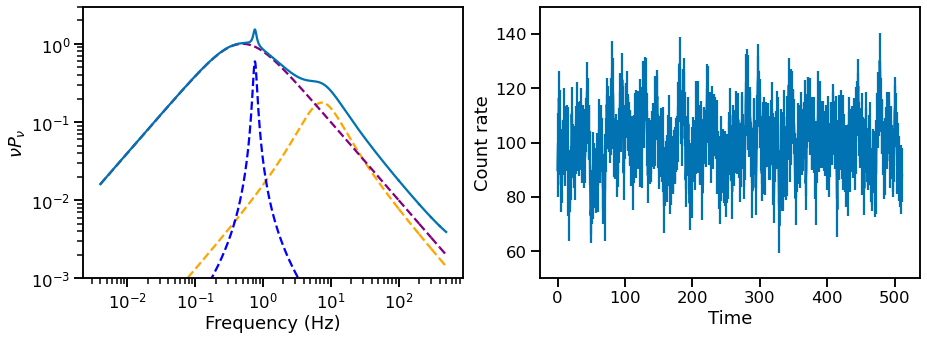

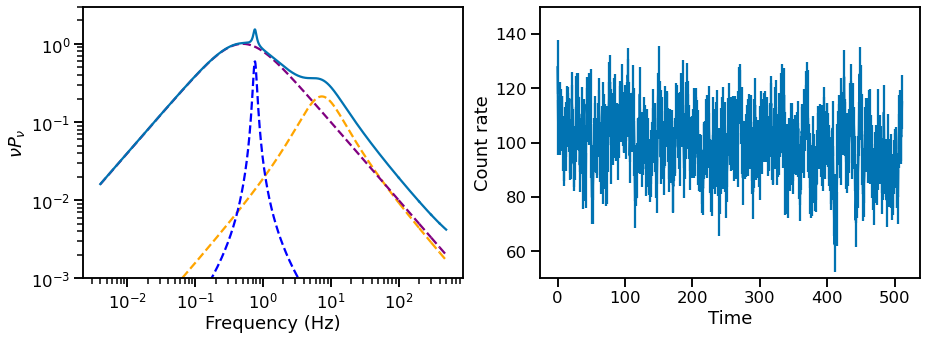

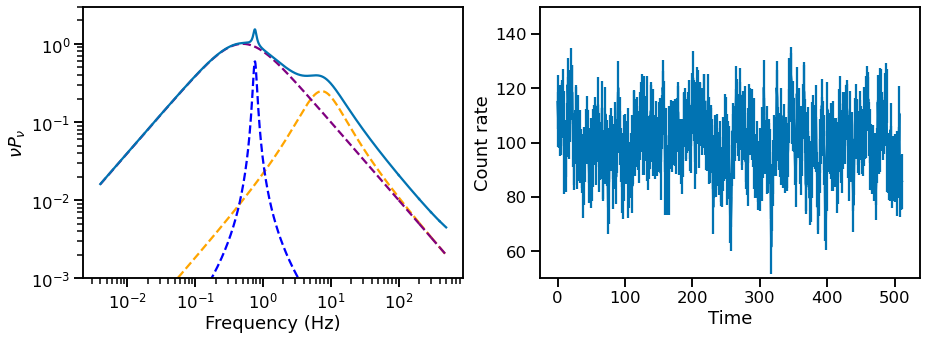

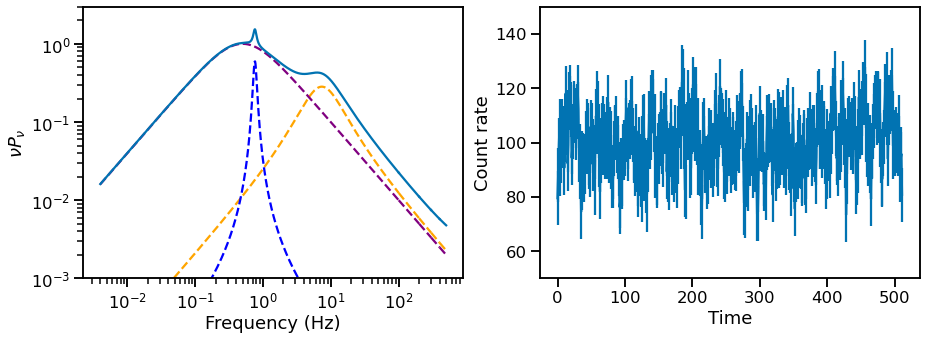

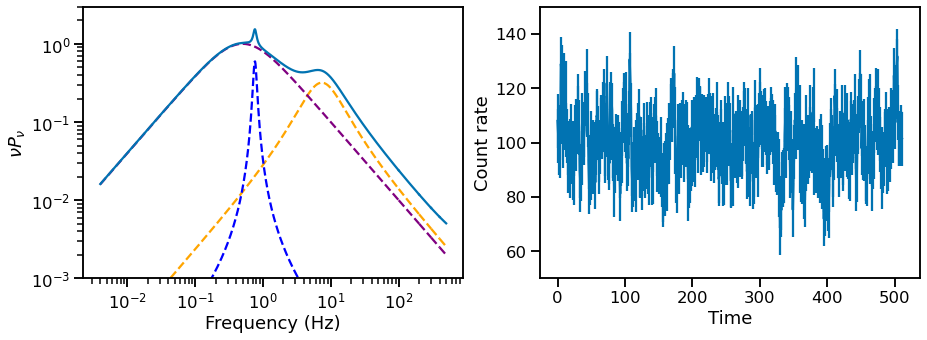

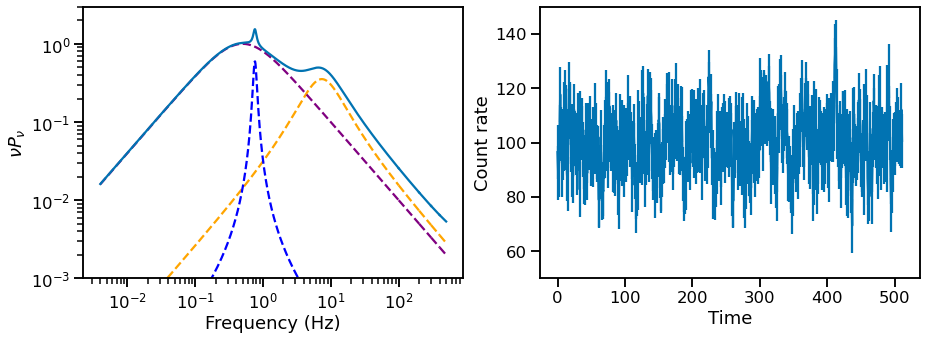

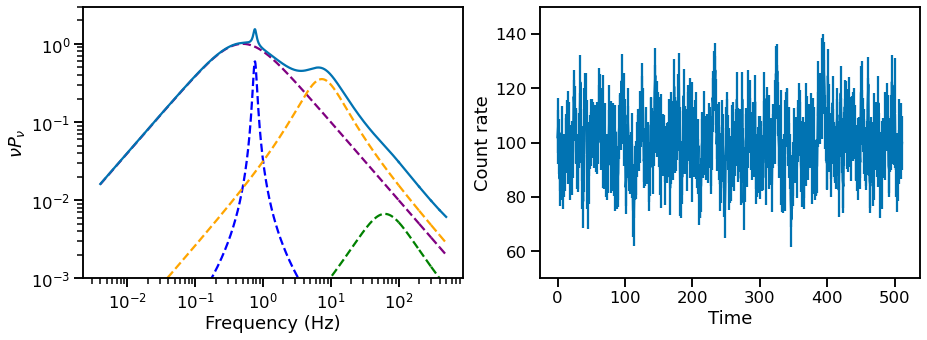

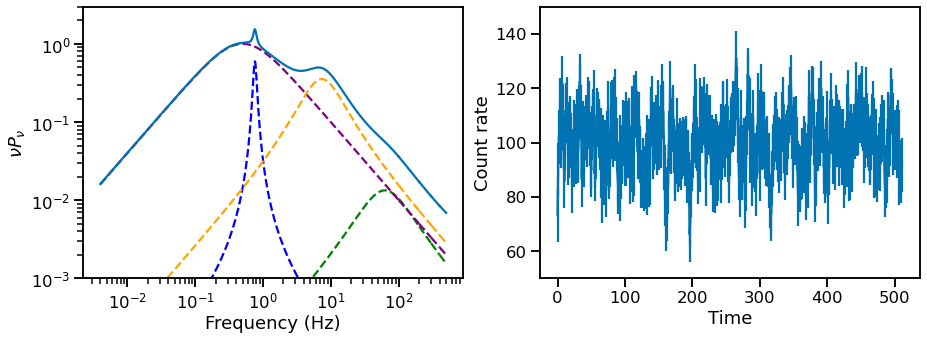

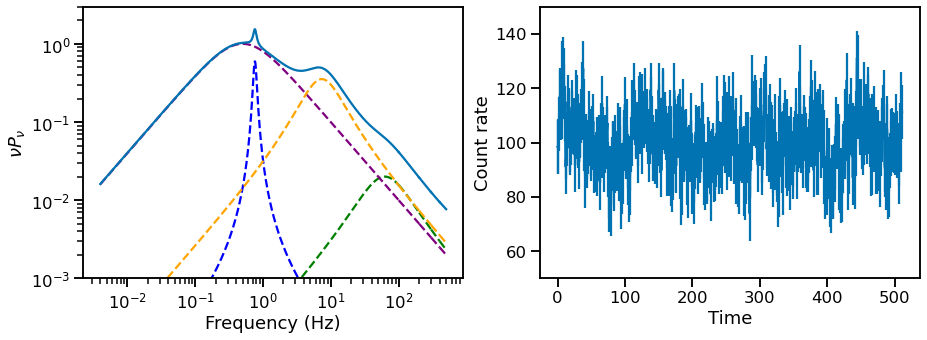

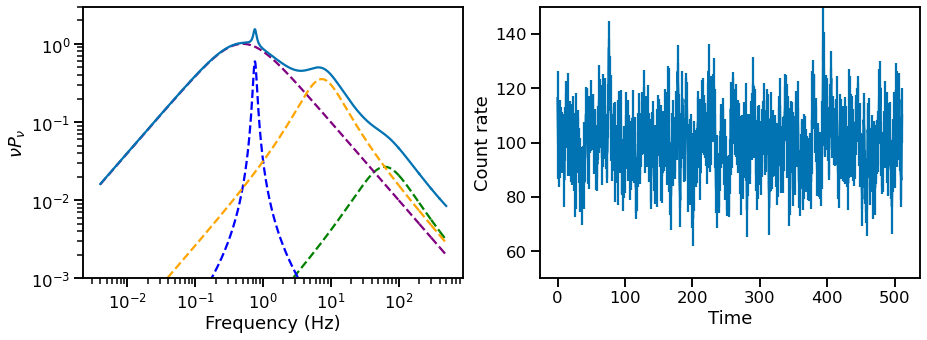

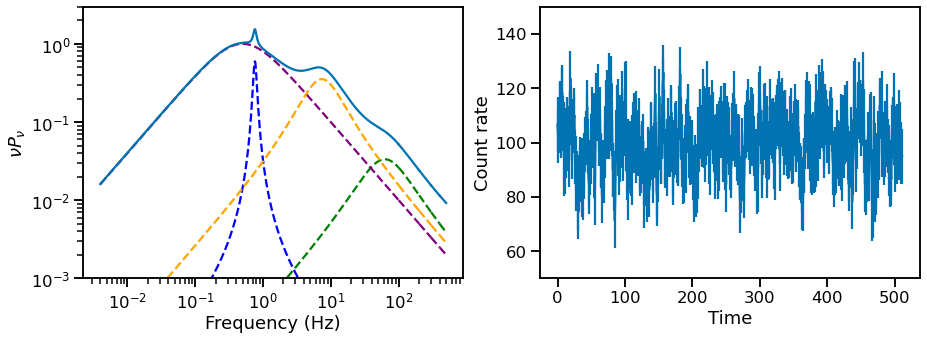

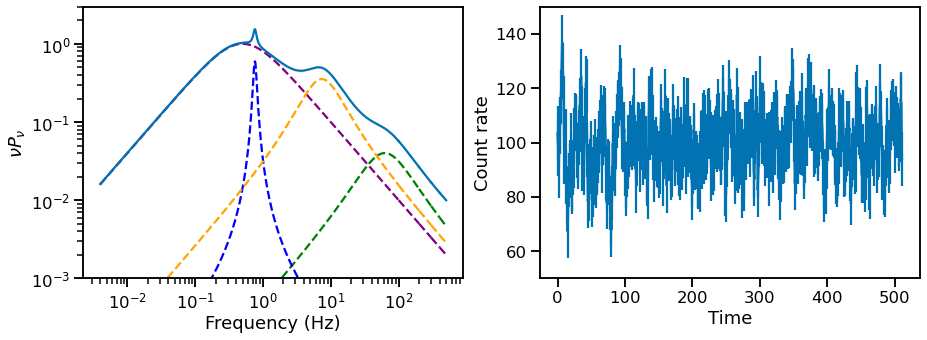

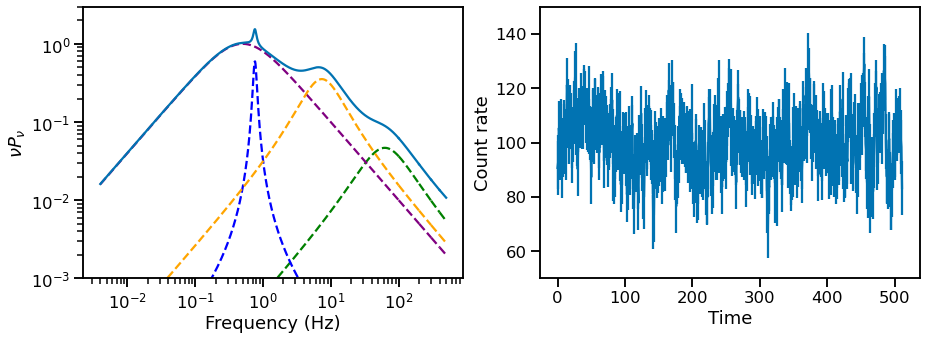

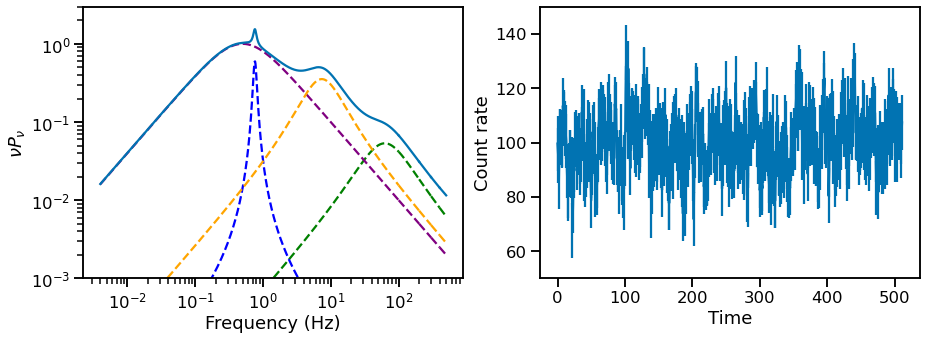

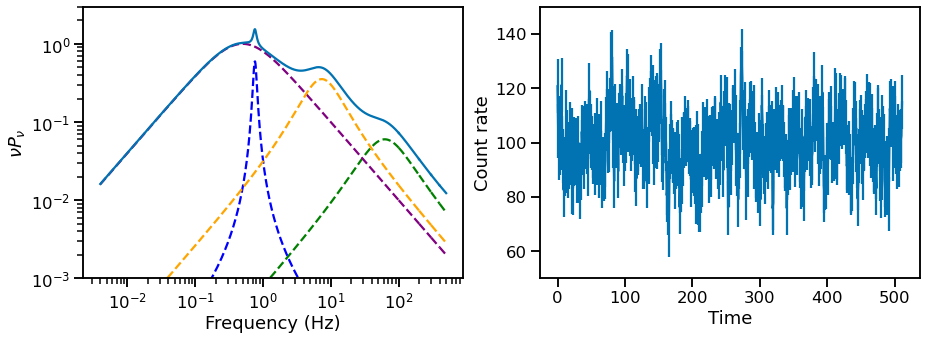

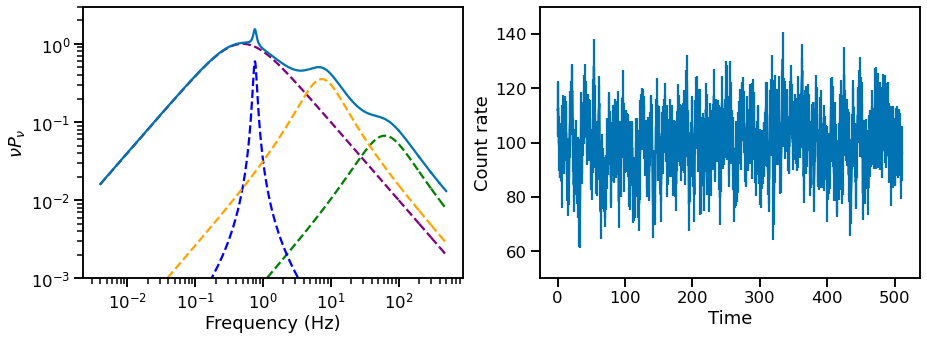

In [9]:
x = np.arange(4e-3, 500., 1e-2)

base_model= np.array([1e-6 for i in range(len(x))])

simulator = sim.Simulator(dt=1.0, N=512, mean = 100., rms=0.01)
fig, (ax1, ax2) = plt.subplots(1,2,  gridspec_kw = {'width_ratios':[1, 1], 'wspace':0.2}, figsize=(15, 5))
ax1.plot(x, base_model*x)
ax1.set_ylabel(r'$\nu P_{\nu}$')
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylim((1e-3, 3))
ax1.loglog()
lc = simulator.simulate(base_model)
ax2.errorbar(lc.time, lc.countrate, xerr=lc.dt, yerr=lc.countrate_err)
ax2.set_ylabel('Count rate')
ax2.set_xlabel('Time')
ax2.set_ylim((50,150))
plt.tight_layout()
plt.show()
# plt.savefig('/Volumes/Samsung_1TB/Ay141/20211119/sim_dir/sim_pds_lc00.pdf')

x_0s= [0.001, 0.758, 5.39, 37.2]
fwhms = [1.0, 0.1, 10.0,100.0]
values= 100. * np.array([0.04, 6e-3/0.758, 3e-3/5.39, 5e-4/37.2])
colors = ['purple', 'blue', 'orange', 'green']

for i in range(len(x_0s)):
    for j, c in enumerate(np.arange(0.1, 1.1, 0.1)):
        tot_model = base_model + mod.generalized_lorentzian(x, [x_0s[i], fwhms[i], c*values[i], 2.0])
        simulator = sim.Simulator(dt=1.0, N=512, mean = 100., rms=0.1)
        fig, (ax1, ax2) = plt.subplots(1,2,  gridspec_kw = {'width_ratios':[1, 1], 'wspace':0.2}, figsize=(15, 5))
        ax1.plot(x, x*mod.generalized_lorentzian(x, [x_0s[i], fwhms[i], c*values[i], 2.0]), color=colors[i], ls='dashed')
        for k in range(i):
            ax1.plot(x, x* mod.generalized_lorentzian(x, [x_0s[k], fwhms[k], values[k], 2.0]), color=colors[k], ls='dashed')
        ax1.plot(x, tot_model*x)
        ax1.set_ylabel(r'$\nu P_{\nu}$')
        ax1.set_xlabel('Frequency (Hz)')
        ax1.set_ylim((1e-3, 3))
        ax1.loglog()
        lc = simulator.simulate(tot_model)
        ax2.errorbar(lc.time, lc.countrate, xerr=lc.dt, yerr=lc.countrate_err)
        ax2.set_ylabel('Count rate')
        ax2.set_xlabel('Time')
        ax2.set_ylim((50,150))
        plt.tight_layout()
        plt.savefig('/Volumes/Samsung_1TB/Ay141/20211119/sim_dir/sim_pds_lc' + str(i+1) + str(j) + '.pdf')
    base_model = tot_model

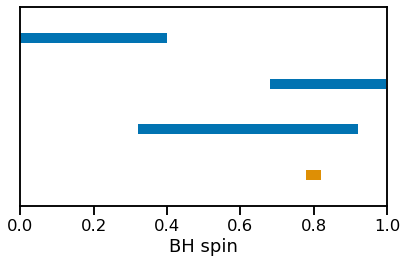

In [24]:
plt.errorbar([0.2,0.998, 0.62], [4, 3, 2], xerr=[[0.3, 0.998-0.68, 0.3],[0.2, 0.0, 0.3]], ls='', lw=10.0)
plt.errorbar([0.799], [1], xerr=[[0.02],[0.02]], ls='', lw=10.0)
plt.yticks([])
plt.xlim((0,1.0))
plt.ylim((0.3,4.7))
plt.xlabel('BH spin')
plt.tight_layout()
plt.savefig('/Users/sean/Desktop/Ay141_1820_spin.pdf')